# CNN Experiments

## Packages and Presets

In [17]:
import torch
import numpy as np
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split  
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torch.utils.tensorboard import SummaryWriter
from sklearn.model_selection import train_test_split
from cnn import CNN
# confusion matrix:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# append grandparent directory to path to make sure we can access the utils file
import sys

sys.path.append("../..")
from utils.utils import (
    get_pneumonia_images,
    PneumoniaDataset,
    set_all_seeds,
    train_and_validate,
    test,
    EarlyStopping,
)

import warnings
warnings.filterwarnings("ignore")

In [18]:
SEED = 42
VALIDATION_SIZE = 0.2

TRAIN_BATCH_SIZE = 16
VAL_BATCH_SIZE = 128
TEST_BATCH_SIZE = 128


N_EPOCHS = 200
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

OPTIMIZER = torch.optim.Adam

LEARNING_RATE = 3e-5
SCHEDULER_STEP_SIZE = 10
SCHEDULER_GAMMA = 0.75

EARLY_STOPPING_START = 100

## Loading and Transforming Pneumonia Images

In [19]:
train_images, train_labels = get_pneumonia_images("../data/chest_xray/train")
val_images, val_labels = get_pneumonia_images("../data/chest_xray/val")
test_images, test_labels = get_pneumonia_images("../data/chest_xray/test")

Reading PNEUMONIA test images: 100%|██████████| 390/390 [00:01<00:00, 326.73it/s]


Since there are so few images (16 in total) in the validation set, we decided to first concatenate the train and validation images and then in a second step split this concatenated dateset into train and enlargened validation set. Further, we will make sure that the classes are similarly unbalanced in the validation set as in the training set. In the current validation set, this is not the case.

In [20]:
train_images_concat = train_images + val_images
train_labels_concat = np.concatenate([train_labels, val_labels])

# overwrite names for memory efficiency
train_images, val_images, train_labels, val_labels = train_test_split(
    train_images_concat,
    train_labels_concat,
    test_size=VALIDATION_SIZE,
    random_state=SEED,
    stratify=train_labels_concat,
)

Finally, we create the transforms for train, validation and test set and then create the torch datasets and dataloaders:

In [21]:
train_transforms = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomGrayscale(),
    transforms.ToTensor()
])

val_transforms = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

In [22]:
# for more info about our custom PneunomiaDataset class see the utils file
train_set = PneumoniaDataset(train_images, train_labels, transforms=train_transforms)
val_set = PneumoniaDataset(val_images, val_labels, transforms=val_transforms)
test_set = PneumoniaDataset(test_images, test_labels, transforms=test_transforms)

In [23]:
# next, we craete the data loaders
train_loader = DataLoader(
    train_set, batch_size=TRAIN_BATCH_SIZE, shuffle=True, pin_memory=True
)
val_loader = DataLoader(
    val_set, batch_size=VAL_BATCH_SIZE, shuffle=False, pin_memory=True
)
test_loader = DataLoader(
    test_set, batch_size=TEST_BATCH_SIZE, shuffle=False, pin_memory=True
)

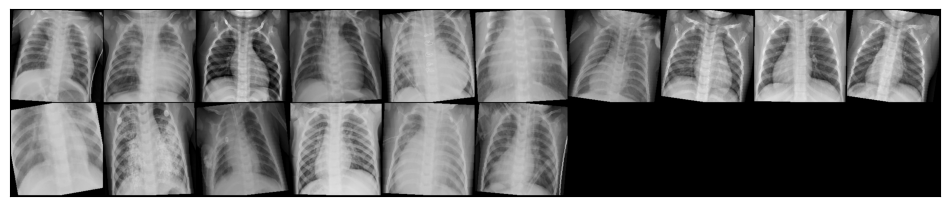

In [24]:
#!!! this code snippet was copied from:
# https://www.kaggle.com/code/teyang/pneumonia-detection-resnets-pytorch

images, labels = next(iter(train_loader))

# Plotting
fig, ax = plt.subplots(figsize=(12, 12))
ax.set_xticks([]); ax.set_yticks([])
ax.imshow(make_grid(images[:60], nrow=10).permute(1, 2, 0))
plt.show()

In [25]:
# Tensorflow tutorial on how to deal with imbalanced data in DeepLearnning
# https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#class_weights
num_0 = np.sum(train_labels == 0)
num_1 = np.sum(train_labels == 1)
weight = torch.tensor(
    [
        (1/num_0) * (num_0 + num_1) / 2.0,
        (1/num_1) * (num_0 + num_1) / 2.0
        
    ], dtype = torch.float32
).to(DEVICE)


criterion = nn.CrossEntropyLoss(weight = weight)

set_all_seeds(SEED)
# laod the model
model = CNN().to(DEVICE)
checkpoint = torch.load("../models/cnn_all_unfrozen.pth", map_location=DEVICE)
model.load_state_dict(checkpoint)
model.eval()
test_loss, test_f1_score, test_balanced_accuracy, model_probs, y_true = test(
    model, test_loader, criterion, device=DEVICE
)

Test Loss: 1.3815765224397183
Test F1 Score: 0.9050410316529894
Test Balanced Accuracy: 0.8303418803418803


## Results

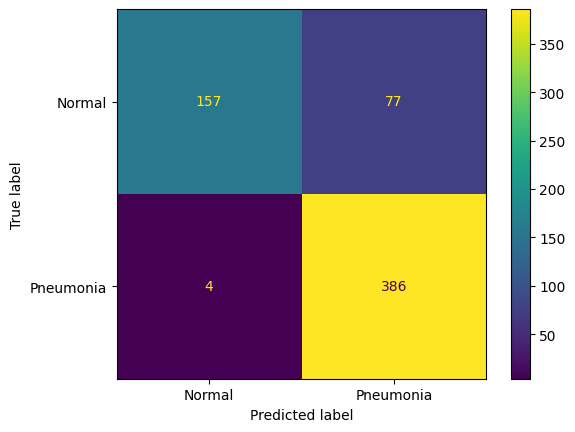

In [26]:
# Plot confusion matrix
labels = y_true
preds = model_probs.round()
cm  = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(cm, display_labels=["Normal", "Pneumonia"])
disp.plot()

In [27]:
# Compute Performance Metrics
tn, fp, fn, tp = cm.ravel()

accuracy = (np.array(preds) == np.array(labels)).sum() / len(preds)
precision = tp/(tp+fp)
recall = tp/(tp+fn)


print(f"Accuracy of the model is {accuracy:.2f}")
print(f"Balanced accuracy of the model is {test_balanced_accuracy:.2f}")
print(f"Recall of the model is {recall:.2f}")
print(f"Precision of the model is {precision:.2f}")
print(f"F1 Score of the model is {test_f1_score:.2f}")

Accuracy of the model is 0.87
Balanced accuracy of the model is 0.83
Recall of the model is 0.99
Precision of the model is 0.83
F1 Score of the model is 0.91


In [28]:
class_data = {0: {"image": [], "prediction" : []}, 1: {"image": [], "prediction" : []}}

for (image, label), prediction in zip(test_set, model_probs.round()):
    if len(class_data[label.item()]["prediction"]) < 5:
        class_data[label.item()]["image"].append(image.numpy().transpose(1, 2, 0))
        class_data[label.item()]["prediction"].append(prediction.astype(int))

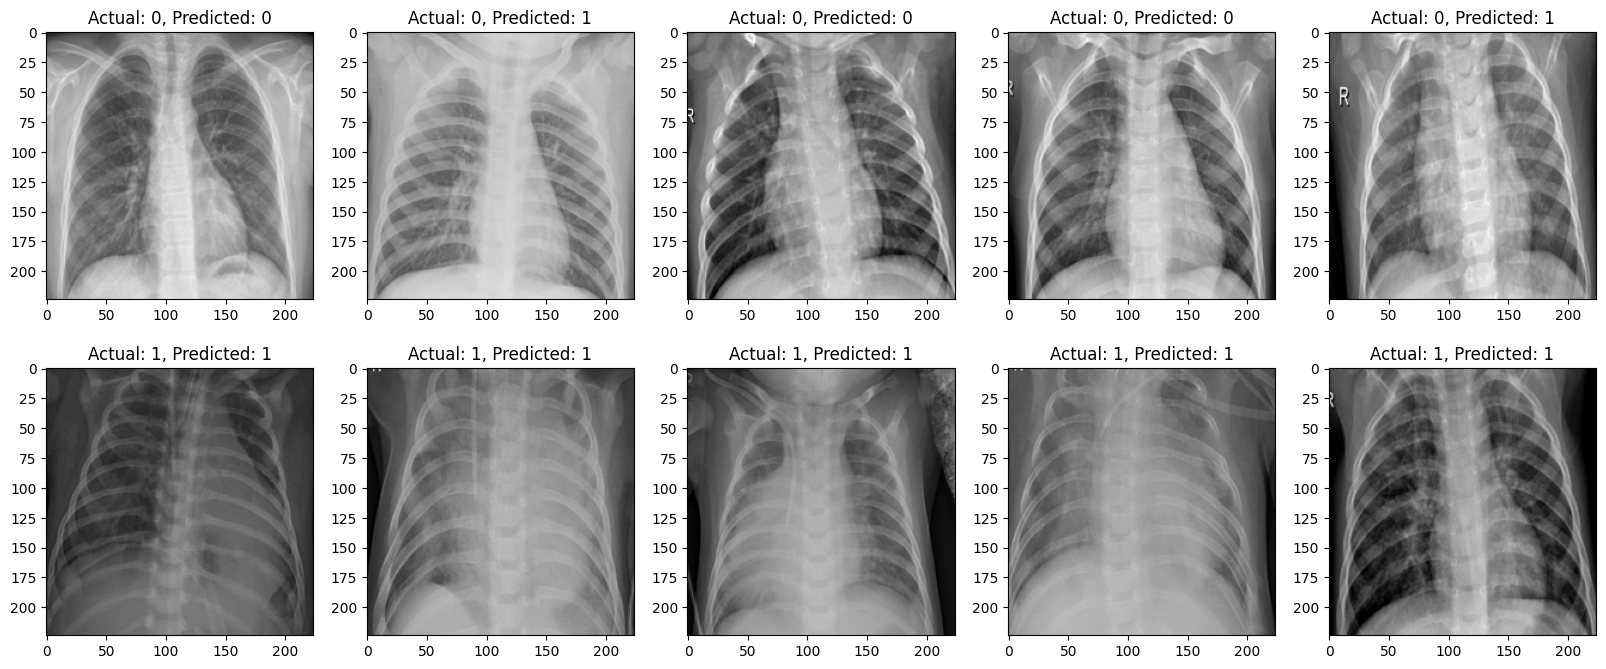

In [29]:
fig, axs = plt.subplots(2, 5, figsize=(20, 8))  # Adjust subplot dimensions as needed

for label, data in class_data.items():
    for i, (image, prediction) in enumerate(zip(data["image"], data["prediction"])):
        ax = axs[label, i]
        ax.imshow(image)
        ax.set_title(f"Actual: {label}, Predicted: {prediction}")